In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense

C:\Users\91944\anaconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\91944\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\91944\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:

# Load your dataset
data = pd.read_csv('MIT-BIH Arrhythmia Database.csv')
data

,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,101,N,76,313.0,0.074347,-0.160548,1.036401,-0.285662,-0.026824,41,...,0.025930,2,18,22,2,0.025930,0.025930,0.025930,0.025436,0.025436
1,101,N,313,315.0,-0.052079,-0.264784,0.886597,-0.366298,-0.059710,21,...,-0.042009,26,27,62,9,-0.042009,-0.029498,0.005012,0.030892,0.002986
2,101,N,315,321.0,-0.062151,-0.296983,0.991859,-0.410306,-0.065686,22,...,0.009528,3,8,12,1,0.009528,0.009528,0.008786,0.008786,0.008368
3,101,N,321,336.0,-0.063322,-0.281386,1.034903,-0.403880,-0.071750,22,...,-0.020536,6,9,16,1,-0.020536,-0.020257,-0.018965,-0.016968,-0.014555
4,101,N,336,344.0,-0.062915,1.046914,1.046408,1.046408,-0.074639,11,...,0.016053,16,5,31,10,0.016053,0.006742,0.002782,-0.007798,-0.051155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100684,234,N,240,241.0,-0.110230,1.420339,1.403346,1.403346,-0.115682,14,...,-0.069234,5,6,20,9,-0.069234,-0.068378,-0.065373,-0.060779,-0.054383
100685,234,N,241,243.0,-0.119014,1.424782,1.420328,1.420328,-0.134406,13,...,-0.069530,7,5,20,8,-0.069530,-0.069290,-0.066317,-0.053437,-0.045120
100686,234,N,243,252.0,0.173524,-0.443214,1.436878,-0.714642,-0.136431,38,...,-0.089396,9,7,24,8,-0.089396,-0.088155,-0.078611,-0.066763,-0.058650
100687,234,N,252,244.0,-0.119820,-0.401522,1.337051,-0.688560,-0.125076,27,...,-0.065487,3,1,12,8,-0.065487,-0.065487,-0.064941,-0.064941,-0.061120


In [3]:
# Data Preparation
# Extract features (excluding 'record' and 'type' columns) and labels (type column)
features = data.drop(['record', 'type'], axis=1).values
labels = data['type'].values

In [4]:

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)


In [5]:

# Encode the labels (convert 'N', 'VEB', etc., to numerical values)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [6]:

# Reshape the features for LSTM input (samples, time steps, features)
# Here, we treat each row as a time step for the sake of the model structure
features_scaled_reshaped = np.expand_dims(features_scaled, axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_scaled_reshaped, labels_encoded, test_size=0.2, random_state=42)


In [7]:

# LSTM Autoencoder Model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    RepeatVector(1),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(X_train.shape[2])),
    # Add a classification head to predict the label (type)
    Dense(64, activation='relu'),
    Dense(len(np.unique(labels_encoded)), activation='softmax')  # Softmax for classification
])

In [8]:

# Compile the model with loss for both reconstruction and classification
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/5
2014/2014 [==============================] - 12s 6ms/step - loss: 0.2828 - accuracy: 0.9289 - val_loss: 0.2068 - val_accuracy: 0.9441
Epoch 2/5
2014/2014 [==============================] - 11s 5ms/step - loss: 0.1908 - accuracy: 0.9450 - val_loss: 0.1747 - val_accuracy: 0.9476
Epoch 3/5
2014/2014 [==============================] - 10s 5ms/step - loss: 0.1673 - accuracy: 0.9493 - val_loss: 0.1594 - val_accuracy: 0.9531
Epoch 4/5
2014/2014 [==============================] - 11s 5ms/step - loss: 0.1537 - accuracy: 0.9530 - val_loss: 0.1457 - val_accuracy: 0.9557
Epoch 5/5
2014/2014 [==============================] - 11s 5ms/step - loss: 0.1425 - accuracy: 0.9560 - val_loss: 0.1557 - val_accuracy: 0.9523


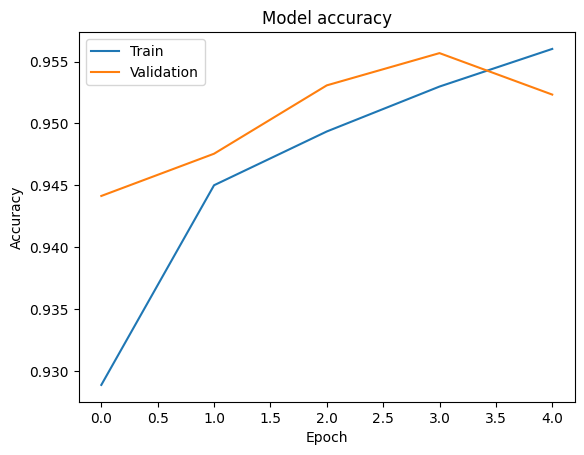

In [9]:

# Plot training & validation accuracy values
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

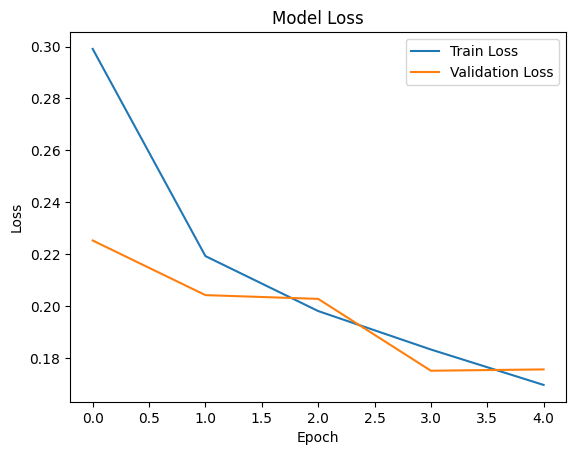

In [12]:

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [10]:

print(X_test[0])
# Now let's predict one sample from the test data
sample = X_test[0].reshape(1, 1, X_train.shape[2])
prediction = model.predict(sample)

# Print the original and predicted type for the sample
predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
original_label = label_encoder.inverse_transform([y_test[0]])

(original_label[0], predicted_label[0])  # Format (Original, Predicted)

print(original_label[0])
print(predicted_label[0])

[[0.14550642 0.14373814 0.44575438 0.62376286 0.64753242 0.70517636
  0.54043089 0.06470588 0.04697987 0.04559271 0.         0.54043089
  0.46831909 0.48673902 0.57389438 0.73512265 0.14550642 0.14373814
  0.29759913 0.38057931 0.61793957 0.75771807 0.578952   0.04230769
  0.05434783 0.04668305 0.0046729  0.578952   0.56155755 0.63673039
  0.55640262 0.68754221]]
N
N


In [11]:
from tensorflow.keras.models import load_model

# Save the model
model.save('lstm_autoencoder_model1.h5')
# Load the model
loaded_model = load_model('lstm_autoencoder_model1.h5')


In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Your custom input data as a list
custom_input = [267, 258, 0.053857278, 0.121722682, 0.494739949, -0.459246103, 0.050227634, 25, 5, 60, 30, 0.050227634, 0.084112393, 0.292198805, 0.493704883, -0.039848932, 267, 258, 0.001155876, 0.381689392, -0.027546461, -0.429080123, -0.027546461, 8, 2, 22, 12, -0.027546461, -0.063113783, -0.174157691, -0.241601522, -0.367118162]


In [13]:

# Normalize the input
scaler = MinMaxScaler()
custom_input_scaled = scaler.fit_transform(np.array(custom_input).reshape(1, -1))

# Reshape for LSTM input (1 sample, 1 time step, number of features)
custom_input_reshaped = custom_input_scaled.reshape(1, 1, -1)
# Make a prediction
prediction = loaded_model.predict(custom_input_reshaped)

# Get the predicted label
predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])
print(f'Predicted label: {predicted_label[0]}')

Predicted label: N
